# PureFacts Point Coverage Problem
> 2022-11-05

Given a set A of points in a 2D space (input.csv - see attached), select an N number of random
Representative Points from this set such that they best "cover" the shape of the point set (as opposed
to its density).
Output should be the source code and 5 separate output.csv files where N = 10, 25, 63, 159, 380

&copy; 2022 Samm Du   
MIT License

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from typing import Optional
from itertools import combinations
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.neighbors import NearestNeighbors

## Data Ingestion

In [2]:
filename: str = "../input.csv"
data = []
with open(filename, "r") as input_file:
    csv_reader = csv.reader(input_file, delimiter=',')
    for line in csv_reader:
        data.append(tuple(int(x) for x in line))


## Configuration

In [3]:
# number of representative points to pick from the input data
NUM_REPS = 10

## Clustering

In [4]:
def mean_of_points(points: list) -> tuple[float, float]:
    """https://stackoverflow.com/a/4355934"""
    return (
        sum([p[0] for p in points]) / len(points), 
        sum([p[1] for p in points]) / len(points)
    )

In [5]:
def point_distance(a: tuple[int, int], b: tuple[int, int]) -> float:
    """Return the Euclidean distance between two 2D input points."""
    return ((b[0] - a[0])**2 + (b[1] - a[1])**2)**(1/2)

### k-Means

In [6]:
kmeans = KMeans(
    n_clusters=NUM_REPS,
    init='random', 
    n_init=80,
    max_iter=300
)
kmeans.fit(data)
kmeans_centroids = kmeans.cluster_centers_

### Hierarchical

In [7]:
hcluster = AgglomerativeClustering(
    n_clusters=NUM_REPS,
    linkage='complete'
)
hcluster.fit(data)
hcluster_labels = hcluster.labels_

hcluster_groups = [[] for i in range(NUM_REPS)]
for point, label in zip(data, hcluster_labels):
    hcluster_groups[label].append(point)

hcluster_centroids = []
for group in hcluster_groups:
    hcluster_centroids.append(mean_of_points(group))

### Birch

In [8]:
brch = Birch(
    n_clusters=NUM_REPS, 
    copy=True
)
brch_labels = brch.fit_predict(data)

birch_groups = [[] for i in range(NUM_REPS)]
for point, label in zip(data, brch_labels):
    birch_groups[label].append(point)

birch_centroids = []
for group in birch_groups:
    birch_centroids.append(mean_of_points(group))

### Graph Disconnect

In [9]:
# create a graph of all points with their position as an attribute
G = nx.Graph()
for id, pos in enumerate(data):
    G.add_node(id, pos=pos)

# generate edges of all points in the graph within a certain radius
# edges_simple = nx.geometric_edges(G, radius=2000)
# G.add_edges_from([
#     (edge[0], edge[1], {"dist": point_distance(data[edge[0]], data[edge[1]])})
#     for edge in edges_simple
# ])

# Ref: https://networkx.org/documentation/stable/_modules/networkx/generators/geometric.html#geometric_edges

# get (node_id, (pos_x, pos_y))
nodes_pos = G.nodes(data="pos")

radius = 6000
num_neighbors = 180
for (u, pu), (v, pv) in combinations(nodes_pos, 2):
    dist_sq = sum(abs(a - b) ** 2 for a, b in zip(pu, pv))
    if ((dist_sq <= radius**2) and 
        (sum(1 for n in G.neighbors(u)) <= num_neighbors) and 
        (sum(1 for n in G.neighbors(v)) <= num_neighbors)):
        G.add_edge(u, v, dist=(dist_sq**(1/2)))


In [10]:
# sort all edges in the graph from short to long in a list
edges_short_to_long = sorted(G.edges(data=True), key=lambda edge: edge[2]['dist'])
print("Total edge count:", len(edges_short_to_long))
print("Total connected components:", nx.number_connected_components(G))

Total edge count: 86050
Total connected components: 1


In [11]:
# keep removing the largest edge from the graph, until the graph has NUM_REPS disconnected components
while nx.number_connected_components(G) < NUM_REPS:
    largest_edge = edges_short_to_long.pop()
    G.remove_edge(largest_edge[0], largest_edge[1])

print("Longest edge:", edges_short_to_long[-1])
print("Total connected components:", nx.number_connected_components(G))

Longest edge: (58, 73, {'dist': 1524.7294842036733})
Total connected components: 10


In [12]:
g_disconn_centroids = [
    mean_of_points([data[i] for i in cluster])
    for cluster in nx.connected_components(G)
]

## 1-NN to Centroids from Input Data

In [13]:
def points_1nn_to_centroids(input_data: list, centroids: list) -> set:
    knn = NearestNeighbors(n_neighbors=1).fit(input_data)
    neighbors_idxs = knn.kneighbors(centroids, n_neighbors=1, return_distance=False)
    
    return set(input_data[x[0]] for x in neighbors_idxs)

### k-Means

In [14]:
kmeans_closest_points_set = points_1nn_to_centroids(data, kmeans_centroids)
kmeans_closest_points = list(kmeans_closest_points_set)
print(kmeans_closest_points)

[(2773, 5788), (3869, 6191), (1199, 8724), (6245, 7039), (7048, 4554), (4291, 3851), (5267, 3372), (7347, 6193), (6580, 5556), (2925, 3861)]


### Hierarchical

In [15]:
hcluster_closest_points_set = points_1nn_to_centroids(data, hcluster_centroids)
hcluster_closest_points = list(hcluster_closest_points_set)
print(hcluster_closest_points)

[(6250, 6915), (1199, 8724), (7214, 4256), (5494, 1672), (3920, 8304), (6880, 5627), (3188, 5989), (4769, 3632), (2925, 3861), (9344, 8190)]


### Birch

In [16]:
birch_closest_points_set = points_1nn_to_centroids(data, birch_centroids)
birch_closest_points = list(birch_closest_points_set)
print(birch_closest_points)

[(7409, 6504), (6460, 5845), (5376, 3389), (3827, 6064), (6200, 7072), (1199, 8724), (4349, 3861), (7031, 4666), (2797, 5812), (2925, 3861)]


### Graph Disconnect

In [17]:
g_disconn_closest_points_set = points_1nn_to_centroids(data, g_disconn_centroids)
g_disconn_closest_points = list(g_disconn_closest_points_set)
print(g_disconn_closest_points)

[(1199, 8724), (3873, 3866), (5494, 1672), (3920, 8304), (7279, 824), (8271, 3538), (6053, 7097), (3188, 5989), (6330, 5237), (9344, 8190)]


## Plotting

In [18]:
def plot_coverage_data(
    plot_title: str, 
    input_data: Optional[list] = None, 
    centroids: Optional[list] = None, 
    closest_points: Optional[list] = None
) -> None:
    colors = ['#444444', '#0784f990', '#fc052ebb']
    point_sizes = [4, 12, 12]
    if (input_data is not None) and len(input_data) > 0:
        plt.scatter(
            [x[0] for x in input_data], 
            [y[1] for y in input_data], 
            s=point_sizes[0],
            color=colors[0]
        )
    if (centroids is not None) and len(centroids) > 0:
        plt.scatter(
            [x[0] for x in centroids], 
            [y[1] for y in centroids], 
            s=point_sizes[1],
            color=colors[1]
        )
    if (closest_points is not None) and len(closest_points) > 0:
        plt.scatter(
            [x[0] for x in closest_points], 
            [y[1] for y in closest_points], 
            s=point_sizes[2],
            color=colors[2]
        )
    plt.title(plot_title)
    plt.show()


### k-Means

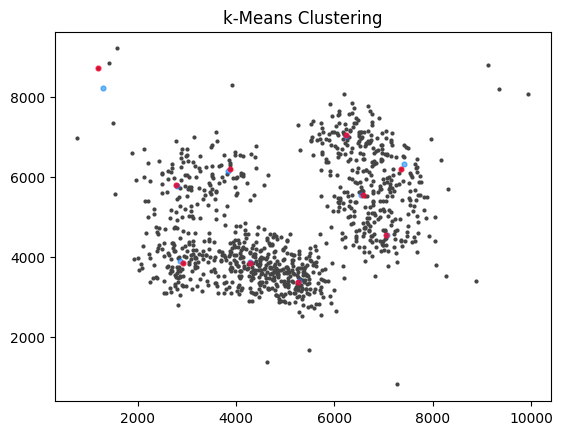

In [19]:
plot_coverage_data(
    "k-Means Clustering", input_data=data, centroids=kmeans_centroids, closest_points=kmeans_closest_points
)

### Hierarchical

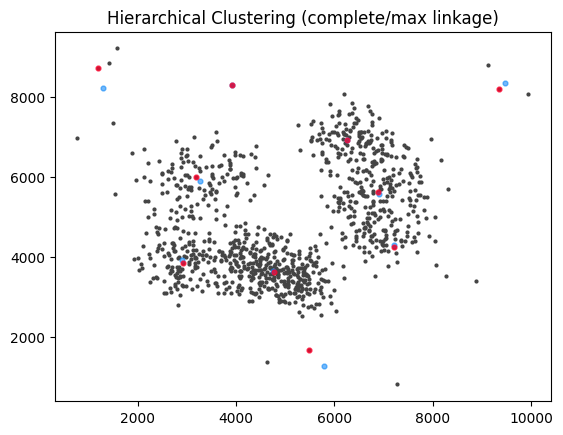

In [20]:
plot_coverage_data(
    "Hierarchical Clustering (complete/max linkage)", input_data=data, centroids=hcluster_centroids, closest_points=hcluster_closest_points
)

### Birch

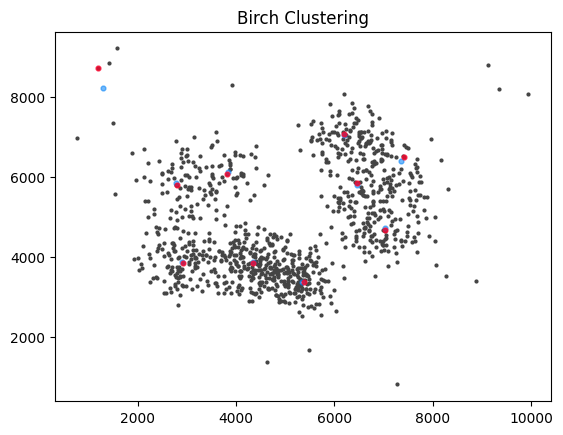

In [21]:
plot_coverage_data(
    "Birch Clustering", input_data=data, centroids=birch_centroids, closest_points=birch_closest_points
)

### Graph Disconnect

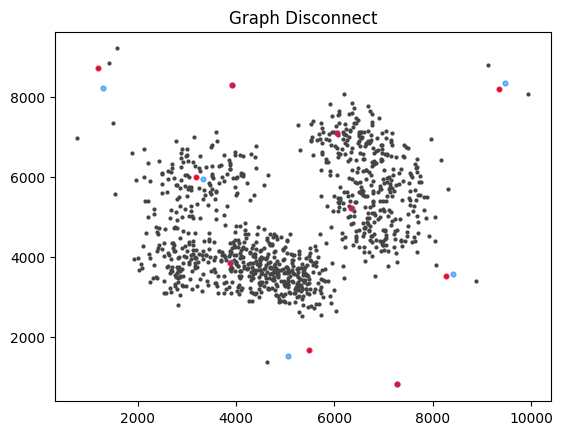

In [22]:
plot_coverage_data(
    "Graph Disconnect", input_data=data, centroids=g_disconn_centroids, closest_points=g_disconn_closest_points
)

## Analysis

### Naive Total Distance to Reps

In [23]:
def data_to_rep_total_dist(input_data: list, reps: list) -> float:
    """
    Return the sum of all distances from a point to all reps
    """
    distance_sum = 0
    for i in input_data:
        for j in reps:
            distance_sum += point_distance(i, j)
    return distance_sum

print("k-Means:\t\t", data_to_rep_total_dist(data, kmeans_closest_points))
print("Hierarchical:\t\t", data_to_rep_total_dist(data, hcluster_closest_points))
print("Birch:\t\t\t", data_to_rep_total_dist(data, birch_closest_points))
print("Graph disconnect:\t", data_to_rep_total_dist(data, g_disconn_closest_points))

k-Means:		 29374051.907928582
Hierarchical:		 34850046.227769665
Birch:			 29516425.26664232
Graph disconnect:	 37936438.93148547


### Distances to Closest Rep Points
Take all points not selected as a rep, find their closest rep,  compute their distance.

In [24]:
def dists_to_closest_rep(input_data: list, reps) -> tuple[float, float, float]:
    """
    Return min, max, average.
    """
    dists_to_closest_rep = []
    for point in input_data:
        if point not in reps:
            closest_rep = min(reps, key=lambda rep: point_distance(point, rep))
            dists_to_closest_rep.append(point_distance(point, closest_rep))
    return min(dists_to_closest_rep), max(dists_to_closest_rep), (sum(dists_to_closest_rep)/len(dists_to_closest_rep))

stats_kmeans = dists_to_closest_rep(data, kmeans_closest_points_set)
stats_hcluster = dists_to_closest_rep(data, hcluster_closest_points_set)
stats_birch = dists_to_closest_rep(data, birch_closest_points_set)
stats_gd = dists_to_closest_rep(data, g_disconn_closest_points_set)

print("Distances from input points to closest rep:")
print("\t\t\t(min, max, average)")

print(f"Stats k-Means: \t\t{stats_kmeans}")
print(f"Stats Hierarchical: \t{stats_hcluster}")
print(f"Stats Birch: \t\t{stats_birch}")
print(f"Stats Graph Disconn: \t{stats_gd}")

Distances from input points to closest rep:
			(min, max, average)
Stats k-Means: 		(2.23606797749979, 3246.6056120200374, 526.0625561140668)
Stats Hierarchical: 	(43.840620433565945, 1976.1905272518638, 639.4778736956712)
Stats Birch: 		(7.0710678118654755, 3193.8431395420785, 533.9813455856188)
Stats Graph Disconn: 	(59.481089431852205, 2120.628444589009, 895.2549394460437)


### Closest Distance Between Reps

In [25]:
def min_dist_between_reps(reps) -> float:
    """
    """
    dist = float('inf')
    for i in reps:
        for j in reps:
            if i != j and (dist_self := point_distance(i, j)) < dist:
                dist = dist_self
    return dist

print("Closest distance between reps:")
print("k-Means:\t", min_dist_between_reps(kmeans_closest_points_set))
print("Hierarchical:\t", min_dist_between_reps(hcluster_closest_points_set))
print("Birch:\t\t", min_dist_between_reps(birch_closest_points_set))
print("Graph Disconn:\t", min_dist_between_reps(g_disconn_closest_points_set))


Closest distance between reps:
k-Means:	 997.0245734183285
Hierarchical:	 1411.0977995872574
Birch:		 1060.3791774643635
Graph Disconn:	 1880.5129619335253
